# Initial analysis

## Executive summary

- most important bullet points
- the validation dataset will be ignored
- not all images seem to be perfectly annotated

## More information

**1 - why ignore the validation dataset**

As observed and explained on the dataset & paper, the validation dataset was a part of the training set. However this makes no sense, so we'll re-split the train set into a new train & validation, find the best hyperparameters based on that, then finally retrain with the best parameters on the train+validation sets.

**2 - EDA**

From the images it is possible to see that the labels and annotations might not be perfect, some seem not to be perfectly annotated, some missing, and such. With that, the model can be only as good as the input data, so that might be a upper limit to its performance.

- xxxx
- xxxx


## imports & configs


In [1]:
#### default imports ####
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### specific imports ###
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from matplotlib.patches import Ellipse

# forces local code to be reloaded to avoid problems
%load_ext autoreload
%autoreload 2

#### important configs ####
# uses seaborn configs for prettier graphs
sns.set_theme()
# shows thousand separator for values
pd.options.display.float_format = '{:,.2f}'.format
# enable import from src/
sys.path.append('..')  

#### paths ####


## auxiliar functions


In [2]:
def get_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    sample_annotations = []

    for neighbor in root.iter("object"):
        label = neighbor.find("name").text
        xmin = int(neighbor.find("bndbox").find("xmin").text)
        ymin = int(neighbor.find("bndbox").find("ymin").text)
        xmax = int(neighbor.find("bndbox").find("xmax").text)
        ymax = int(neighbor.find("bndbox").find("ymax").text)

        #     print(xmin, ymin, xmax, ymax)
        sample_annotations.append([label, xmin, ymin, xmax, ymax])

    return sample_annotations

# 1 - validation dataset problem


In [3]:
# where the images & labels are
raw_path = "../data/raw"

# gets the path for all files
df_all = pd.DataFrame()
for dirname, _, filenames in os.walk(raw_path):
    paths = [dirname + "/" + filename for filename in filenames]
    folder_name = os.path.split(dirname)[-1]
    df_all = pd.concat([df_all, pd.DataFrame({"path": paths})], ignore_index=True)

# transforms to df
df_all = pd.DataFrame(df_all)

# also gets the filename
df_all["filename"] = df_all["path"].apply(lambda s: s.split("/")[-1])

# and finally check possible extensions
extensions = df_all["path"].apply(lambda s: s.split(".")[-1])
extensions.value_counts()

path
xml                  420
jpg                  420
txt                  420
gitkeep                1
/data/raw/LICENSE      1
md                     1
yml                    1
cache                  1
Name: count, dtype: int64

In [4]:
# creates a reference for the dataset (which folder it is from)
df_all["dataset"] = df_all["path"].apply(lambda s: s.split("/")[-3])
df_all["dataset"].value_counts()

dataset
Training      900
Testing       180
Validation    180
data            4
raw             1
Name: count, dtype: int64

In [5]:
# check if all the files in validation dataset are also in the training one
for filename in df_all[df_all["dataset"] == "Validation"]["filename"]:
    if filename not in df_all[df_all["dataset"] == "Training"]["filename"].values:
        print(filename)

**Conclusion:** Here it is possible to observe that all files in the validation folder are (as explained in the paper & GitHub) duplicated from the training dataset. This utilization is a methodological problem, so will not be used in our study.


# 2 - EDA


[['RBC', 452, 200, 587, 308], ['RBC', 357, 319, 465, 420], ['RBC', 295, 379, 403, 480], ['RBC', 108, 222, 216, 323], ['RBC', 197, 379, 305, 480], ['RBC', 440, 24, 548, 125], ['RBC', 362, 1, 470, 100], ['RBC', 575, 269, 640, 366], ['RBC', 290, 113, 355, 210], ['RBC', 226, 293, 331, 382], ['RBC', 1, 357, 107, 473], ['Platelets', 479, 290, 519, 326], ['WBC', 9, 1, 137, 103]]
[['RBC', 216, 279, 330, 379], ['RBC', 117, 345, 230, 475], ['RBC', 452, 314, 566, 414], ['RBC', 385, 317, 499, 417], ['RBC', 505, 222, 608, 325], ['RBC', 488, 179, 588, 271], ['RBC', 477, 57, 577, 149], ['RBC', 426, 70, 526, 162], ['RBC', 376, 169, 482, 272], ['RBC', 1, 179, 96, 278], ['RBC', 1, 1, 96, 98], ['RBC', 286, 197, 382, 296], ['WBC', 123, 1, 361, 196]]
[['WBC', 250, 196, 405, 337], ['Platelets', 5, 455, 38, 480], ['Platelets', 596, 259, 640, 307]]


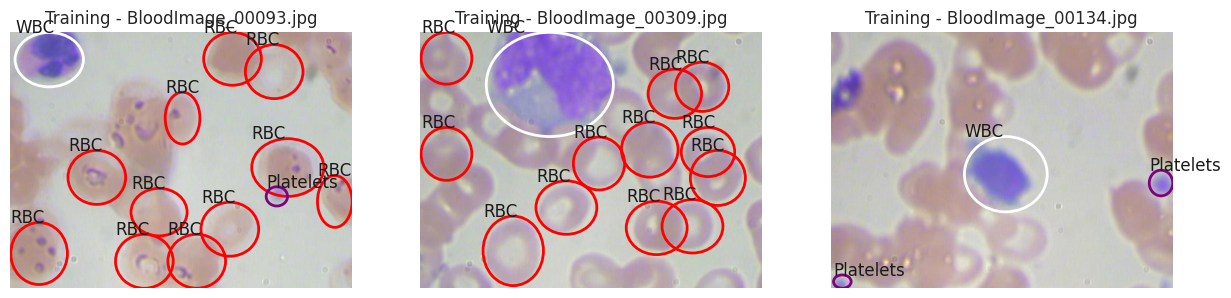

In [6]:
# select only images
images = df_all[df_all["filename"].apply(lambda s: s.split(".")[-1] in ["jpg"])]

label_colors = {"RBC": "red", "WBC": "white", "Platelets": "purple"}

# show 3 images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, (index, row) in enumerate(images.sample(3, random_state=42).iterrows()):
    # img show
    img = plt.imread(row["path"])
    ax[i].imshow(img)
    ax[i].axis("off")
    ax[i].set_title(f"{row['dataset']} - {row['filename']}")

    # get annotations
    annotations = get_annotations(
        row["path"].replace("Images", "Annotations").replace("jpg", "xml")
    )
    print(annotations)

    # show annotations
    for label, xmin, ymin, xmax, ymax in annotations:
        ax[i].add_patch(
            # plt.Rectangle(
            #     (xmin, ymin),
            #     xmax - xmin,
            #     ymax - ymin,
            #     linewidth=2,
            #     edgecolor=label_colors[label],
            #     facecolor="none",
            # )
            Ellipse(
                ((xmin + xmax) / 2, (ymin + ymax) / 2),
                xmax - xmin,
                ymax - ymin,
                linewidth=2,
                edgecolor=label_colors[label],
                facecolor="none",
            )
        )
        ax[i].text(xmin, ymin, label, fontsize=12, color="k")

**Info:** From the images it is possible to see that the labels and annotations might not be perfect, some seem not to be perfectly annotated, some missing, and such. With that, the model can be only as good as the input data, so that might be a upper limit to its performance.


# 4 - hyperparameter tuning


In [7]:
# definitions for the dataset
WIDTH = 640
HEIGHT = 480
cells_id = {"RBC": 0, "WBC": 1, "Platelets": 2}

cells_classes = list(cells_id.keys())
cells_classes
# saves the dataset into the yolo format
for i, (index, row) in enumerate(images.iterrows()):
    # get annotations
    annotations = get_annotations(
        row["path"].replace("Images", "Annotations").replace("jpg", "xml")
    )

    # get label path
    label_path = row["path"].replace("Images", "Labels").replace("jpg", "txt")

    # create folders
    os.makedirs(os.path.split(label_path)[0], exist_ok=True)

    # save annotations
    with open(label_path, "w") as file:
        for label, xmin, ymin, xmax, ymax in annotations:
            # get the center of the rectangle
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2

            # normalize the values
            x_center /= WIDTH
            y_center /= HEIGHT
            width = (xmax - xmin) / WIDTH
            height = (ymax - ymin) / HEIGHT

            # save the values
            file.write(f"{cells_id[label]} {x_center} {y_center} {width} {height}\n")

print("done!")

done!


## .1 - initial baseline


In [8]:
# %cd ..
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# %pip install -r requirements.txt

In [9]:
# !cat ../yolov5/data/coco128.yaml

In [10]:
# yaml_file = "../yolov5/data/blood_cell.yaml"
# train_images_dir = "../data/raw/Training/Images/"
# val_images_dir = "../data/raw/Testing/Images/"

# names_str = ""
# for item in cells_classes:
#     names_str = names_str + ", '%s'" % item
# names_str = "names: [" + names_str[1:] + "]"

# with open(yaml_file, "w") as wobj:
#     wobj.write("train: %s\n" % train_images_dir)
#     wobj.write("val: %s\n" % val_images_dir)
#     wobj.write("nc: %d\n" % len(cells_classes))
#     wobj.write(names_str + "\n")

In [11]:
# print("toto")

In [12]:
# %cd yolov5
# !bash weights/download_weights.sh

In [13]:
# pip install opencv-python-headless

In [14]:
# print("toto")

In [15]:
# ls

In [16]:
# !python train.py --data data/blood_cell.yaml --batch-size 4 --epochs 3 --img-size 640 --project runs/train --name blood_cell --weights weights/yolov5s.pt --device 0

In [17]:
# !python train.py --data data/blood_cell.yaml --batch-size 4 --epochs 3 --img-size 640 --weights weights/yolov5s.pt --device 0

In [18]:
ls

1-nmb_initial-analysis.ipynb*  yolov8n.pt*


## .2 - ultralitcs


In [19]:
print("toto")

toto


In [20]:
from ultralytics import YOLO

# Load a model
# model = YOLO('yolov8n.yaml')  # build a new model from YAML
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)
# model = YOLO('yolov8n.yaml').load('yolov8n.pt')  # build from YAML and transfer weights

# Train the model
# results = model.train(data="coco128.yaml", epochs=2, imgsz=640)

In [21]:
model.predict("../data/raw/Training/Images/BloodImage_00000.jpg")


image 1/1 /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/notebooks/../data/raw/Training/Images/BloodImage_00000.jpg: 480x640 (no detections), 167.5ms
Speed: 4.7ms preprocess, 167.5ms inference, 57.7ms postprocess per image at shape (1, 3, 480, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [22]:
results = model("../data/raw/Training/Images/BloodImage_00000.jpg")


image 1/1 /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/notebooks/../data/raw/Training/Images/BloodImage_00000.jpg: 480x640 (no detections), 5.0ms
Speed: 3.1ms preprocess, 5.0ms inference, 0.5ms postprocess per image at shape (1, 3, 480, 640)


In [25]:
model("../data/raw/Training/Images/BloodImage_00000.jpg", show=True)

image 1/1 /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/notebooks/../data/raw/Training/Images/BloodImage_00000.jpg: 480x640 (no detections), 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 480, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
model("../data/raw/Training/Images/BloodImage_00000.jpg", show=True)

In [28]:
results = model.train(data="../blood_cell.yaml", epochs=2, imgsz=640)

New https://pypi.org/project/ultralytics/8.1.34 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.1.33 🚀 Python-3.11.8 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=../blood_cell.yaml, epochs=2, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None,

train: Scanning /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Training/Images... 0 images, 300 backgrounds, 0 corrupt: 100%|██████████| 300/300 [00:00<00:00, 452.92it/s]

train: WARNING ⚠️ No labels found in /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Training/Images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


train: New cache created: /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Training/Images.cache
WARNING ⚠️ No labels found in /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Training/Images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


val: Scanning /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Testing/Images... 0 images, 60 backgrounds, 0 corrupt: 100%|██████████| 60/60 [00:00<00:00, 311.30it/s]

val: WARNING ⚠️ No labels found in /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Testing/Images.cache. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.


val: New cache created: /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Testing/Images.cache
WARNING ⚠️ No labels found in /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/data/raw/Testing/Images.cache, training may not work correctly. See https://docs.ultralytics.com/datasets/detect for dataset formatting guidance.
Plotting labels to /home/branco/runs/detect/train4/labels.jpg... 
zero-size array to reduction operation maximum which has no identity
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /home/branco/runs/detect/train4
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_l

        1/2       2.2G          0      122.9          0          0        640: 100%|██████████| 19/19 [00:12<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2       2.2G          0      111.4          0          0        640: 100%|██████████| 19/19 [00:04<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  7.58it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels



2 epochs completed in 0.005 hours.
Optimizer stripped from /home/branco/runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from /home/branco/runs/detect/train4/weights/best.pt, 6.2MB

Validating /home/branco/runs/detect/train4/weights/best.pt...
Ultralytics YOLOv8.1.33 🚀 Python-3.11.8 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce RTX 3050 6GB Laptop GPU, 6144MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  5.42it/s]

                   all         60          0          0          0          0          0
WARNING ⚠️ no labels found in detect set, can not compute metrics without labels


Speed: 0.2ms preprocess, 2.3ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to /home/branco/runs/detect/train4


In [32]:
model("../data/raw/Training/Images/BloodImage_00000.jpg", show=True)

image 1/1 /mnt/c/Users/nicol/My Drive/personal/coding projects/2024/blood-cell-detection/notebooks/../data/raw/Training/Images/BloodImage_00000.jpg: 480x640 (no detections), 63.9ms
Speed: 4.0ms preprocess, 63.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [25]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [27]:
# Process results list
result = results
boxes = result.boxes  # Boxes object for bounding box outputs
masks = result.masks  # Masks object for segmentation masks outputs
keypoints = result.keypoints  # Keypoints object for pose outputs
probs = result.probs  # Probs object for classification outputs
result.show()  # display to screen

AttributeError: 'list' object has no attribute 'boxes'

## .3 - pre & post-processing


# 5 - retraining


# 6 - model results


# 7 - Analisys


# 8 - conclusion
